# Tutorial 11: time series

There are some features how LightAutoML makes forecast for time-series tasks:

- multi-output strategy for forecasting time series if horizon is more than 1 point (forecast simultaneously over the entire horizon)
- global-modelling approach for handling multiple time series (one model for all time series in the dataset)

In this tutorial you will learn how to:

- run LightAutoML training on data with one or many time series
- configure time series features transformers' parameters

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML).

## 0. Prerequisites

### 0.0. install LightAutoML

In [ ]:
# !pip install -U lightautoml

### 0.1. Import libraries

In [2]:
# Standard python libraries
import os

# Installed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Imports from our package
from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import DictToPandasSeqReader
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.random_forest import RandomForestSklearn

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

### 0.2. Constants and functions

Here we setup the constants to use in the kernel:
- `HORIZON` - number of points to forecast 
- `TARGET_COLUMN` - target column name in dataset
- `DATE_COLUMN` - date column name in dataset
- `ID_COLUMN` - id column name in dataset

In [3]:
HORIZON = 30
TARGET_COLUMN = "value"
DATE_COLUMN = "date"
ID_COLUMN = "ID"

In [4]:
def draw_raw_ts(
    data: pd.DataFrame,
    id_column: str,
    target_column: str,
    date_column: str,
    ncols: int = 2,
):
    """Draw graphs of time series with specified parameters.
    Args:
        - data: pd.DataFrame with time series data
        - id_column: id column name in dataset
        - target_column: target column name in dataset
        - date_column: date column name in dataset
        - ncols: number of columns for subplot's grid
    """
    # Initialize grid's shape
    num_ts = data[id_column].nunique()
    nrows = num_ts // ncols + num_ts % ncols
    fig, ax = plt.subplots(
        nrows, 
        ncols, 
        figsize=(24, 5 * nrows)
    )
    axes_to_del = nrows * ncols - num_ts
    for i in range(axes_to_del):
        i_row = (nrows - 1) - i // ncols
        i_col = (ncols - 1) - i % ncols
        fig.delaxes(ax[i_row][i_col])
    
    # Draw graphs
    for i, ts_id in enumerate(data[id_column].unique()):
        i_row = i // ncols
        i_col = i % ncols
        
        ts_df = data[data[id_column] == ts_id]
        ax = ax.reshape(nrows, ncols)
        ax[i_row, i_col].plot(ts_df[date_column], ts_df[target_column])
        ax[i_row, i_col].title.set_text(f"TS with ID {ts_id}")

### 0.3. Data loading

In [5]:
df = pd.read_csv('../data/ts_data.csv')
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])
display(df.head())
print(f"data shape: {df.shape}")
print(f"number of time series in data: {df[ID_COLUMN].nunique()}")


,date,value,ID
0,2020-01-01,2.100760,0
1,2020-01-02,2.106072,0
2,2020-01-03,2.291461,0
3,2020-01-04,2.322224,0
4,2020-01-05,2.140932,0


data shape: (10000, 3)
number of time series in data: 5


This data is simulated and presented time series, contained such components as trend, seasonality, events and future reg.

On the cell below we draw our time series:

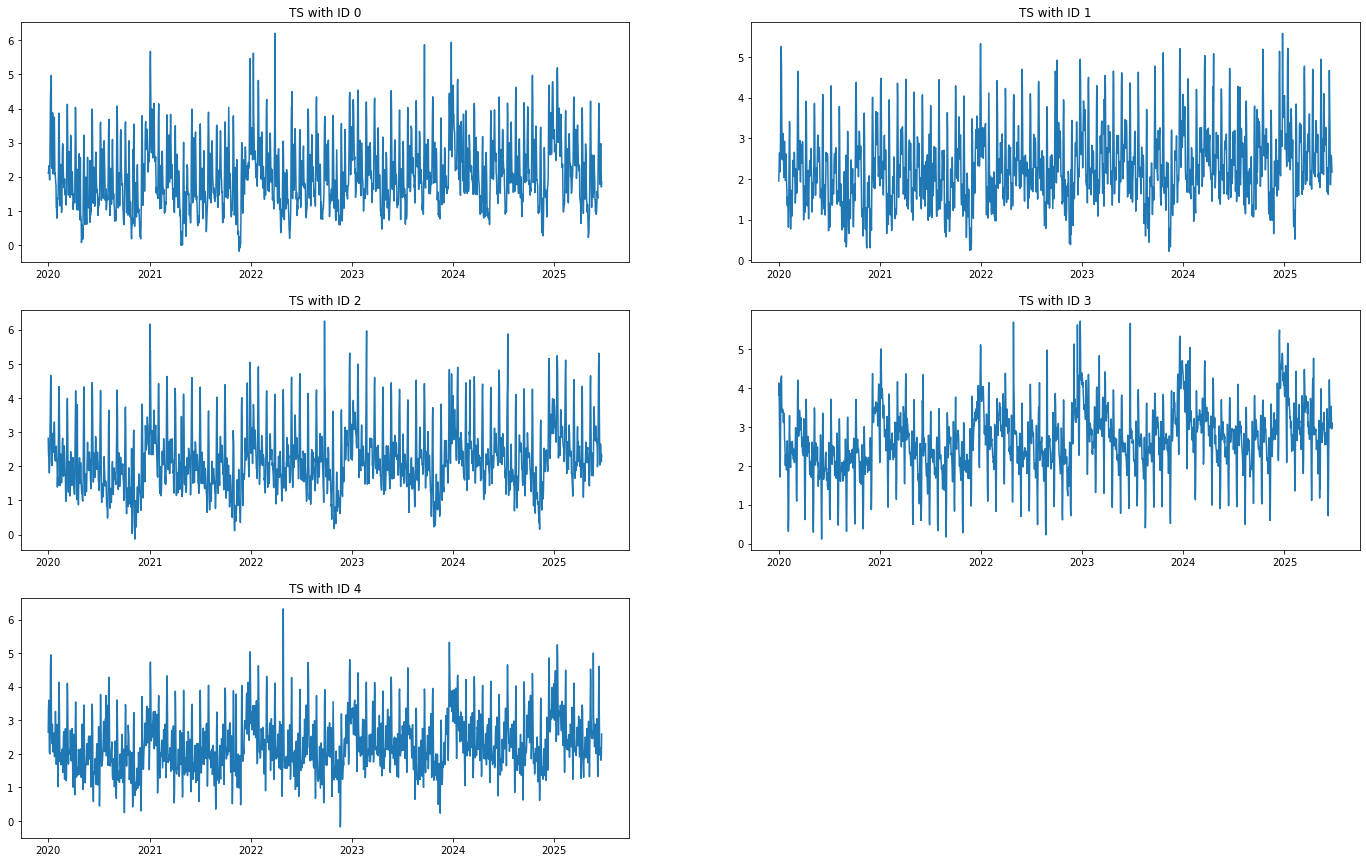

In [6]:
draw_raw_ts(df, ID_COLUMN, TARGET_COLUMN, DATE_COLUMN)

### 0.4. Data splitting for train-holdout

Let's make forecast of 30 next points. So, we should make train-test-split for each times series in our data. 

In [7]:
# Assume, that our time series are aligned and have identical timestamps.
test_start = df[df[ID_COLUMN] == 0][DATE_COLUMN].values[-HORIZON]  

train = df[df[DATE_COLUMN] < test_start].copy()
test = df[df[DATE_COLUMN] >= test_start].copy()

# 1. Task definition

## 1.1. Task type

On the cell below we create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation). For time series forecasting it should setted as "multi:reg":

In [8]:
task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")

multi:reg isn`t supported in lgb


## 1.2. Feature roles setup

The only role you must setup is ```"target"``` role, everything else (date, categorical, etc.) is up to user. 

But if we have several time series in data, it is recommended to setup ```"id"``` role to group our observations. Also we can define seasonal features through `DatetimeRole`. Valid are: `y`, `m`, `d`, `wd`, `hour`, `min`, `sec`, `ms`, `ns`.

In [9]:
univariate_roles = {
    "target": TARGET_COLUMN,
    DatetimeRole(seasonality=('d', 'm', 'wd'), base_date=True): DATE_COLUMN,
}

global_modelling_roles = {
    "target": TARGET_COLUMN,
    DatetimeRole(seasonality=('d', 'm', 'wd'), base_date=True): DATE_COLUMN,
    "id": ID_COLUMN
}

## 1.3. LightAutoML (AutoTS) model creation

In this part we are going to create LightAutoML model with ```AutoTS``` class.

The params we can setup:
- ```task``` - the type of the ML task (we defined it earlier)
- ```seq_params``` - parameter for Reader object, which works on the first step of data preparation:
  - ```case``` - the type of problem we are solving (```next_values```: prediction of next values)
  - ```n_target``` - forecasting horizon
  - ```history``` - history size for feature generating (i.e., features for observation $y_t$ are counted from observations ($y_{t-history}$, ..., $y_{t-1}$))
  - ```step``` - in how many points to take the next observation in the training sample (the higher the step value --> the fewer observations fall into the training sample)
  - ```test_last``` - technical parameter: test data are built by the last observation from the training sample
  - ```from_last``` - technical parameter: build train features from last possible observation.
- ```transformers_params``` - parameter for Transformer objects, which are needed to make features from raw time series
  - ```lag_features``` - *bool/int/list/array*: lags to make lag features for features other than date
  - ```lag_time_features``` - *bool/int/list/array*: lags to make lag features for date features
  - ```diff_features``` - *bool/int/list/array*: lags to make difference features for features other than date
- ```trend_params``` - parameter for TrendModel object, which is needed to detrend the time series before using the main AutoML class 

__Note:__ Patameters within the transformers_params may be configured as True/False, or integer, list, numpy-array:
- __True__: use default values (lag_other_features=30, lag_time_features=30, diff_features=7)
- __int__: use all lags and diffs up to the input number (range)
- __list__: use certain lags and diffs specified in the list

---

There are some figures which can be helpful for better understanding these params:

Firstly, let's generalise regression task of time series forecasting: 
- with known values for timestamps from $T_{N+1}$ to $T_0$ we should predict ones for timestamps $T_{1}, ..., T_{F}$

<img src="../../imgs/tutorial_11_general_problem_statement.png" alt="Time series general problem statement"/>

- assume that $N=10$ and $F = 3$ and get train and test index arrays for values in time series:

<img src="../../imgs/tutorial_11_case_problem_statement.png" alt="Time series case problem statement"/>

Firstly, the graph below is about ```history``` and ```step``` parameters:

<img src="../../imgs/tutorial_11_history_step_params.png" alt="History and step params description"/>

Now let's take the first case and understand how ```transformers_params``` work and how train and test samples look like after transformations:

<img src="../../imgs/tutorial_11_transformers_params.png" alt="Transformers params description"/>

In [10]:
seq_params = {
    "seq0": {
        "case": "next_values",                  
        "params": {
            "n_target": HORIZON,                
            "history": HORIZON,                              
            "step": 1, 
            "from_last": True,
            "test_last": True
        }
    }
}

transformers_params = {
    "lag_features": 30,
    "lag_time_features": 30,
    "diff_features": [1, 2, 3, 4, 5, 6, 7, 14],
}

# You can try specify parameters for trend model too
# trend_params = {
#     'trend': False,
#     'train_on_trend': False,
#     'trend_type': 'decompose',  # one of 'decompose', 'decompose_STL', 'linear' or 'rolling'
#     'trend_size': 1, 
#     'decompose_period': 30, 
#     'detect_step_quantile': 0.01, 
#     'detect_step_window': 1, 
#     'detect_step_threshold': 0.7,
#     'rolling_size': 1, 
#     'verbose': 0
# }

automl = AutoTS(
    task,
    reader_params = {
        "seq_params": seq_params
    },
    time_series_trend_params={
        "trend": False,
    },
    time_series_pipeline_params=transformers_params
)

**Important note**: `reader_params`, `time_series_trend_params`, `time_series_pipeline_params`, `general_params` keys are the YAML config keys, which is used inside `TabularAutoML` preset. More details on its structure with explanation comments can be found inside the `lightautoml/automl/presets/time_series_config.yaml` file. Each key from this config can be modified with user settings during both to providing .yml file and modifying while AutoTS class initialization like in the cell above. 

# 2. AutoML training

## 2.1. Univariate LightAutoML

In [11]:
# leave only ts with ID = 4
ID = 4

univariate_train = train[train[ID_COLUMN] == ID].drop("ID", axis=1)
univariate_test = test[test[ID_COLUMN] == ID].drop("ID", axis=1)

In [12]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [13]:
univariate_train_pred, _ = automl.fit_predict(univariate_train, univariate_roles, verbose=4)
univariate_forecast, _ = automl.predict(univariate_train)

[10:24:17] Stdout logging level is DEBUG.
[10:24:17] Task: multi:reg

[10:24:17] Start automl preset with listed constraints:
[10:24:17] - time: 3600.00 seconds
[10:24:17] - CPU: 4 cores
[10:24:17] - memory: 16 GB

[17:58:26] Layer 1 train process start. Time left 3599.96 secs
[17:58:26] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[17:58:26] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'mse'}
[17:58:26] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[17:58:27] Score for RF model: -0.474507
[17:58:27] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[17:58:28] Score for RF model: -0.468268
[17:58:28] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finish

Let's take a look on forecasts of univariate time series and check MAE

In [14]:
print(univariate_forecast, "\n")
print(f"MAE: {mean_absolute_error(univariate_test.value, univariate_forecast)}")

[3.44697142 3.073035   2.49203897 2.1270709  2.29297566 2.70116901
 2.83488226 2.49551201 2.16700649 1.99528813 2.31517577 2.87421489
 3.00472379 2.59042096 1.8664093  1.47073889 1.81992817 2.58693051
 3.36398268 3.59384632 3.24508047 2.63568759 2.20735097 1.9374007
 1.74858916 1.72028816 1.79335809 2.08676887 2.57858872 3.18161464] 

MAE: 0.22544950642226508


Get a graph of model's predictions in comparison with true values 

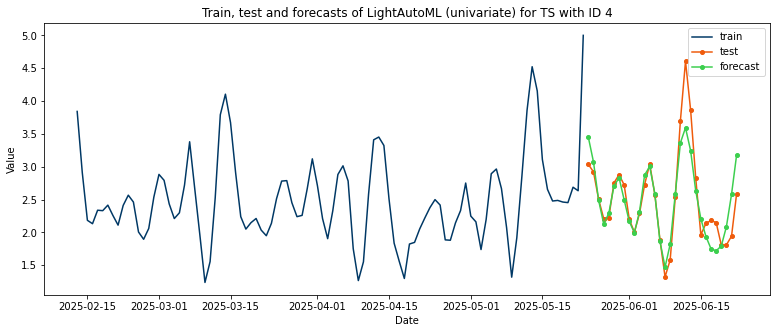

In [15]:
last_N = min(len(train), 100)

fig = plt.figure(figsize=(13, 5))
plt.plot(
    univariate_train[DATE_COLUMN][-last_N:], 
    univariate_train[TARGET_COLUMN][-last_N:], 
    c="#003865", 
    label="train"
)
plt.plot(
    univariate_test[DATE_COLUMN], 
    univariate_test[TARGET_COLUMN], 
    c="#EF5B0C", 
    label="test", 
    marker="o", 
    markersize=4
)
plt.plot(
    univariate_test[DATE_COLUMN], 
    univariate_forecast, 
    c="#3CCF4E", 
    label="forecast", 
    marker="o", 
    markersize=4
)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title(f"Train, test and forecasts of LightAutoML (univariate) for TS with ID {ID}")
plt.legend()
plt.show()

One by one make forecasts for all time series in dataset and collect them to a new pd.DataFrame:

In [16]:
ID_array = np.repeat(df[ID_COLUMN].unique(), HORIZON)
test_array = np.array([])
pred_array = np.array([])
date_array = np.array([]).astype("datetime64")

for ts_id in df[ID_COLUMN].unique():
    univariate_train = train[train[ID_COLUMN] == ts_id]
    univariate_test = test[test[ID_COLUMN] == ts_id]
    
    # Model fit_predict
    _, _ = automl.fit_predict(univariate_train, univariate_roles)
    univariate_forecast, _ = automl.predict(univariate_train)
    pred_array = np.append(pred_array, univariate_forecast)
    test_array = np.append(test_array, univariate_test[TARGET_COLUMN].values)
    date_array = np.append(date_array, univariate_test[DATE_COLUMN].values)
    
# Collect results
res_df_dict = {
    "ID": ID_array,
    "pred": pred_array,
    "date": date_array,
    "test": test_array
}

res_df_univariate = pd.DataFrame(res_df_dict)

In [17]:
res_df_univariate.head()

,ID,pred,date,test
0,0,2.427282,2025-05-24,1.581092
1,0,3.297728,2025-05-25,2.376163
2,0,3.508930,2025-05-26,2.627754
3,0,3.071776,2025-05-27,2.105468
4,0,2.333910,2025-05-28,1.969833


Check MAE for all time series:

In [18]:
mae_df_univariate = res_df_univariate.groupby("ID").apply(
    lambda x: mean_absolute_error(x["test"], x["pred"])
).reset_index()

mae_df_univariate.columns = ["ID", "MAE_univariate"]
mae_df_univariate

,ID,MAE_univariate
0,0,0.371187
1,1,0.292606
2,2,0.435712
3,3,0.376864
4,4,0.225450


## 2.2. Global-modelling LightAutoML

In [19]:
# Duplicate ID column for better feature generating
train["id_2"] = train[ID_COLUMN]

In [20]:
oof_pred_seq = automl.fit_predict(train, roles=global_modelling_roles, verbose=4)
seq_test = automl.predict(train, return_raw=True)

[10:34:19] Stdout logging level is DEBUG.
[10:34:19] Task: multi:reg

[10:34:19] Start automl preset with listed constraints:
[10:34:19] - time: 3600.00 seconds
[10:34:19] - CPU: 4 cores
[10:34:19] - memory: 16 GB

[18:05:37] Layer 1 train process start. Time left 3599.91 secs
[18:05:38] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[18:05:38] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'mse'}
[18:05:38] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[18:05:40] Score for RF model: -0.478922
[18:05:40] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[18:05:43] Score for RF model: -0.477559
[18:05:43] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finish

```seq_test``` соis consisted of:
   - seq_test.date — base date, from which predictions are made
   - seq_test.id — id of time series
   - seq_test.data — predictions themselves

We can collect these values to the df.DataFrame:

In [21]:
freq = pd.infer_freq(train[DATE_COLUMN].iloc[:10])
date_list = [seq_test.date[0] + pd.Timedelta(1+i, unit=freq) for i in range(HORIZON)]
date_list = date_list * len(seq_test.id)
pred_list = list(seq_test.data.reshape(-1))
id_list = np.repeat(seq_test.id, HORIZON)

df_dict = {
    "ID": id_list,
    "date": date_list,
    "pred": pred_list
}

res_df_global = pd.DataFrame(df_dict)
res_df_global = res_df_global.merge(test, on=["ID", "date"])

res_df_global

,ID,date,pred,value
0,0,2025-05-24,2.384080,1.581092
1,0,2025-05-25,3.279628,2.376163
2,0,2025-05-26,3.530711,2.627754
3,0,2025-05-27,3.079974,2.105468
4,0,2025-05-28,2.362342,1.969833
...,...,...,...,...
145,4,2025-06-18,1.874377,2.149213
146,4,2025-06-19,1.947542,1.807998
147,4,2025-06-20,2.211135,1.810103
148,4,2025-06-21,2.608910,1.941590


Check MAE for all time series:

In [22]:
mae_df_global = res_df_global.groupby("ID").apply(
    lambda x: mean_absolute_error(x["value"], x["pred"])
).reset_index()

mae_df_global.columns = ["ID", "MAE_global"]
mae_df_global

,ID,MAE_global
0,0,0.344390
1,1,0.227540
2,2,0.477782
3,3,0.342722
4,4,0.193969


Compare MAE for two strategies (univariate/local- and global-modelling):

In [23]:
mae_df_global.merge(mae_df_univariate, on=["ID"])

,ID,MAE_global,MAE_univariate
0,0,0.344390,0.371187
1,1,0.227540,0.292606
2,2,0.477782,0.435712
3,3,0.342722,0.376864
4,4,0.193969,0.225450


Lastly, get a graph of models' predictions in comparison with each other and the true values

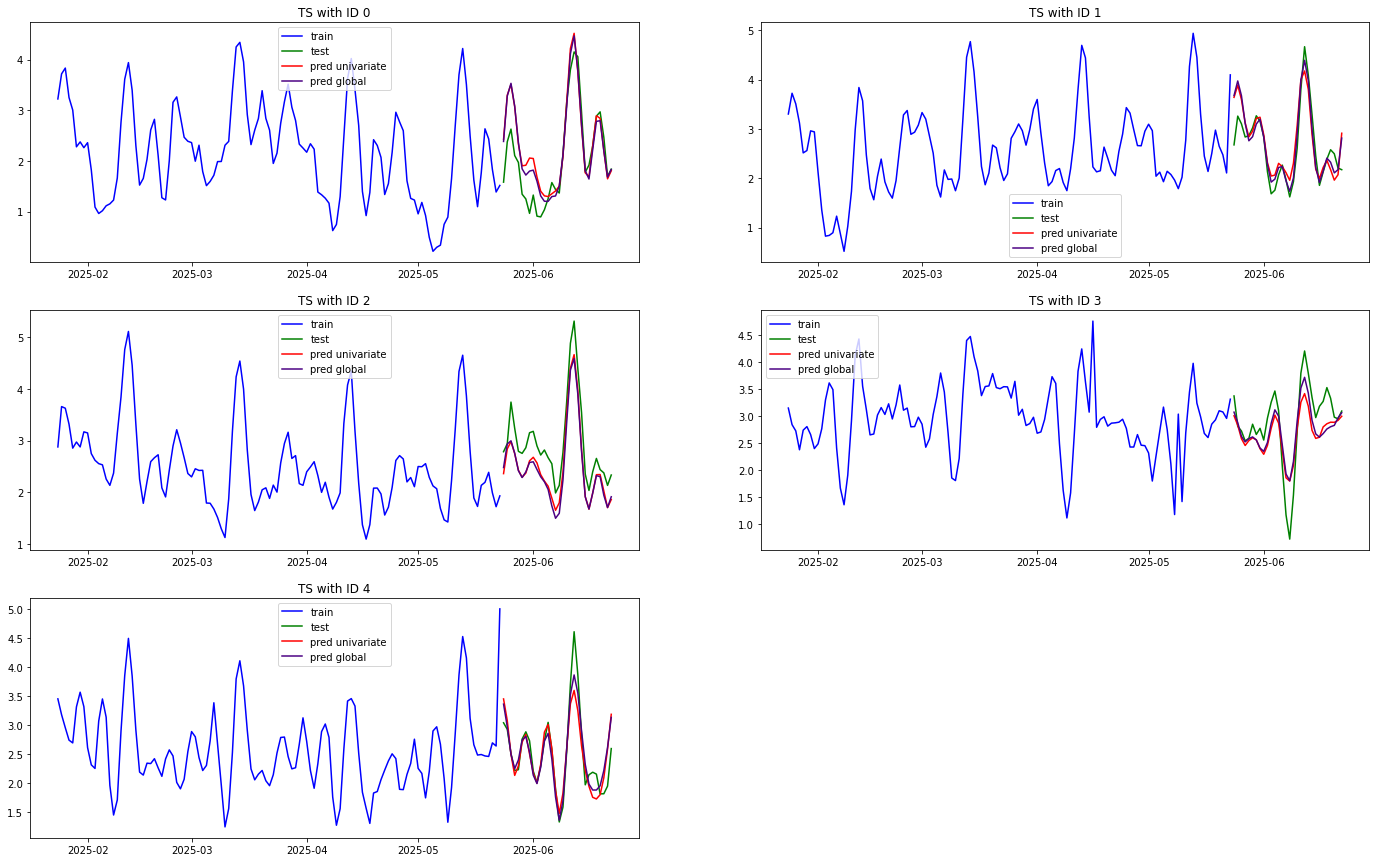

In [24]:
LAST_TRAIN_N = 120

num_ids = len(df[ID_COLUMN].value_counts())
subplots_num_columns = 2
subplots_num_rows = num_ids // 2 + num_ids % 2
fig, ax = plt.subplots(
    subplots_num_rows, 
    subplots_num_columns, 
    figsize=(24, 5 * subplots_num_rows)
)

for i, ts_id in enumerate(df[ID_COLUMN].unique()):
    i_row = i // 2
    i_col = i % 2
    
    current_train = train[train[ID_COLUMN] == ts_id]
    current_res_df_univariate = res_df_univariate[res_df_univariate[ID_COLUMN] == ts_id]
    current_res_df_global = res_df_global[res_df_global[ID_COLUMN] == ts_id]
    
    ax[i_row, i_col].plot(current_train[DATE_COLUMN][-LAST_TRAIN_N:], current_train[TARGET_COLUMN][-LAST_TRAIN_N:], c='b', label='train')
    ax[i_row, i_col].plot(current_res_df_univariate[DATE_COLUMN], current_res_df_univariate["test"], c='g', label='test')
    ax[i_row, i_col].plot(current_res_df_univariate[DATE_COLUMN], current_res_df_univariate["pred"], c='r', label='pred univariate')
    ax[i_row, i_col].plot(current_res_df_global[DATE_COLUMN], current_res_df_global["pred"], c='indigo', label='pred global')

    ax[i_row, i_col].title.set_text(f"TS with ID {ts_id}")
    ax[i_row, i_col].legend()
    
axes_to_del = i_row * subplots_num_rows + i_col * subplots_num_columns - num_ids
for i in range(axes_to_del):
    i_row = (subplots_num_rows - 1) - i // 2
    i_col = (subplots_num_columns - 1) - i % 2
    fig.delaxes(ax[i_row][i_col])
    
plt.show();

## Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)